<a href="https://colab.research.google.com/github/NickN94/AI-Learning-Center/blob/main/Absatzprognose_%26_Lageroptimierung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Bibliotheken installieren & importieren

# Installationen (falls noch nicht vorhanden)
!pip install pandas matplotlib seaborn

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook-Einstellungen
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

Train Shape: (913000, 4)
Test Shape: (45000, 4)

Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None

Null-Werte:
 date     0
store    0
item     0
sales    0
dtype: int64

Beispielhafte Zeilen:


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


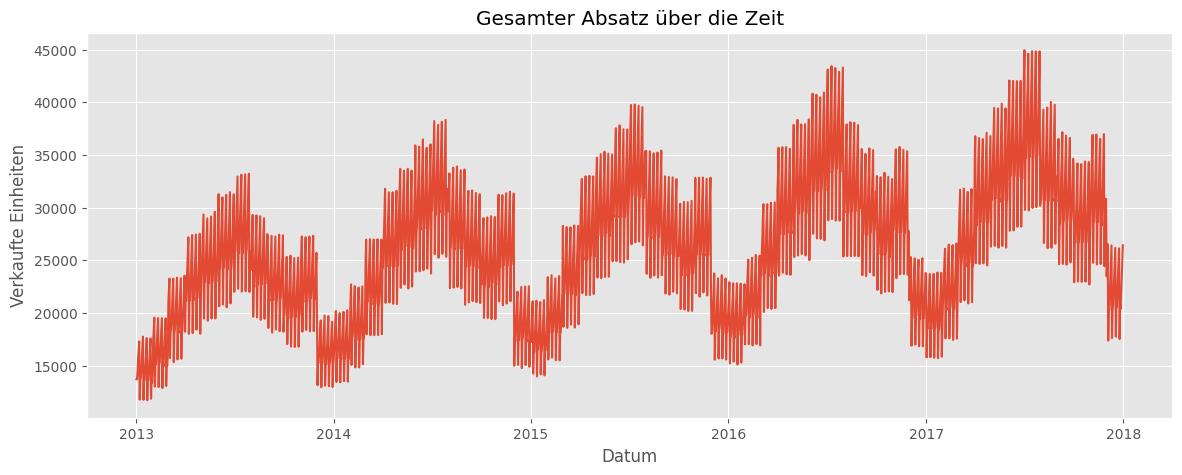

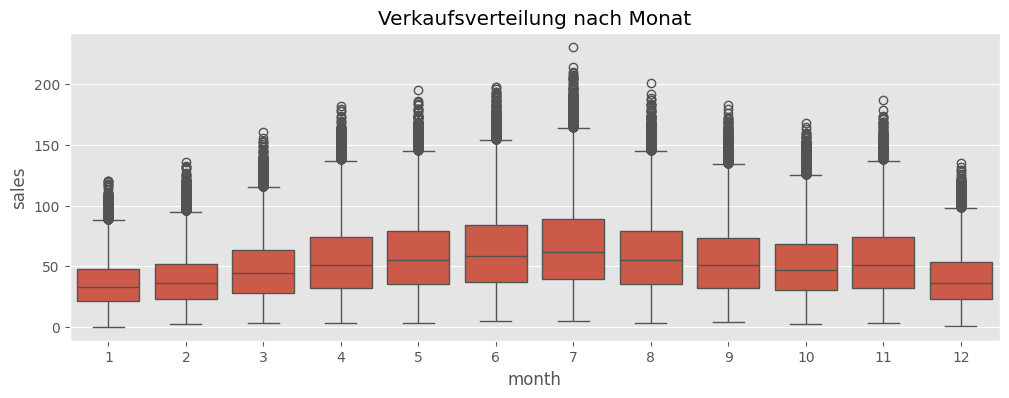

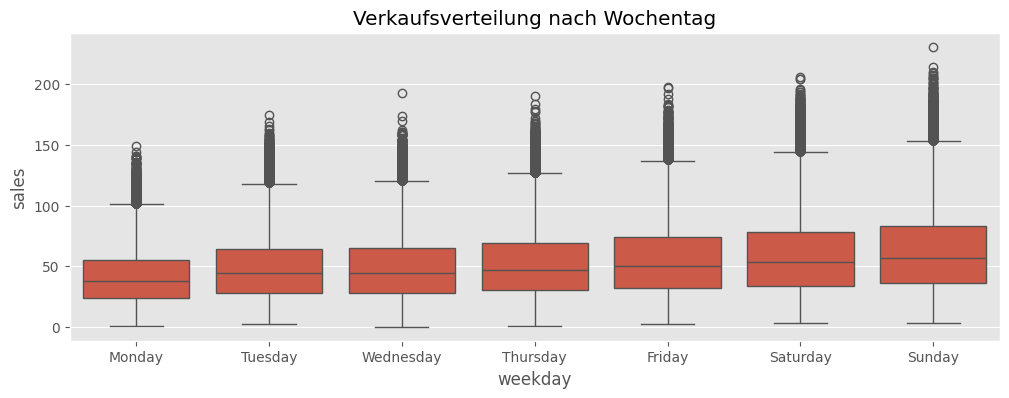

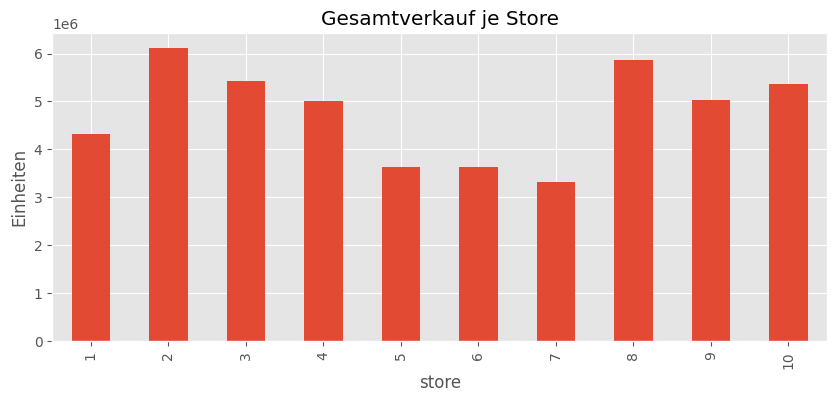

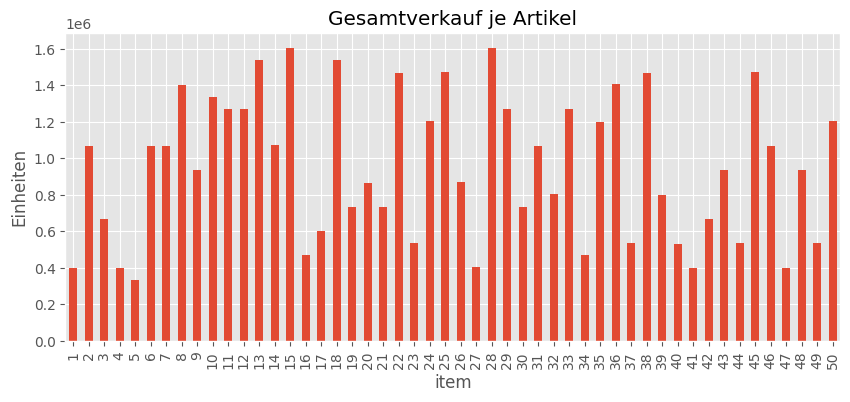

In [3]:
# Daten Laden
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

# Erste Analyse
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
print("\nTrain Info:")
print(train.info())
print("\nNull-Werte:\n", train.isnull().sum())
print("\nBeispielhafte Zeilen:")
display(train.head())

# Datum als Zeitstempel
train['date'] = pd.to_datetime(train['date'])

# === Schritt 4: Aggregierte Zeitreihe
daily_sales = train.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(14, 5))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title("Gesamter Absatz über die Zeit")
plt.xlabel("Datum")
plt.ylabel("Verkaufte Einheiten")
plt.grid(True)
plt.show()

# === Schritt 5: Saisonale Muster nach Monat & Wochentag
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.day_name()

plt.figure(figsize=(12,4))
sns.boxplot(x='month', y='sales', data=train)
plt.title("Verkaufsverteilung nach Monat")
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(x='weekday', y='sales', data=train, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Verkaufsverteilung nach Wochentag")
plt.show()

# === Schritt 6: Store- & Item-Analyse
plt.figure(figsize=(10,4))
store_sales = train.groupby('store')['sales'].sum()
store_sales.plot(kind='bar')
plt.title("Gesamtverkauf je Store")
plt.ylabel("Einheiten")
plt.show()

plt.figure(figsize=(10,4))
item_sales = train.groupby('item')['sales'].sum()
item_sales.plot(kind='bar')
plt.title("Gesamtverkauf je Artikel")
plt.ylabel("Einheiten")
plt.show()

In [4]:
# Prophet installieren (falls nicht vorhanden)
!pip install prophet

from prophet import Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyte_yps8/2dzfd3ex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyte_yps8/e2po6r8g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91814', 'data', 'file=/tmp/tmpyte_yps8/2dzfd3ex.json', 'init=/tmp/tmpyte_yps8/e2po6r8g.json', 'output', 'file=/tmp/tmpyte_yps8/prophet_modelgeixeicn/prophet_model-20250719174809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:48:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:48:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


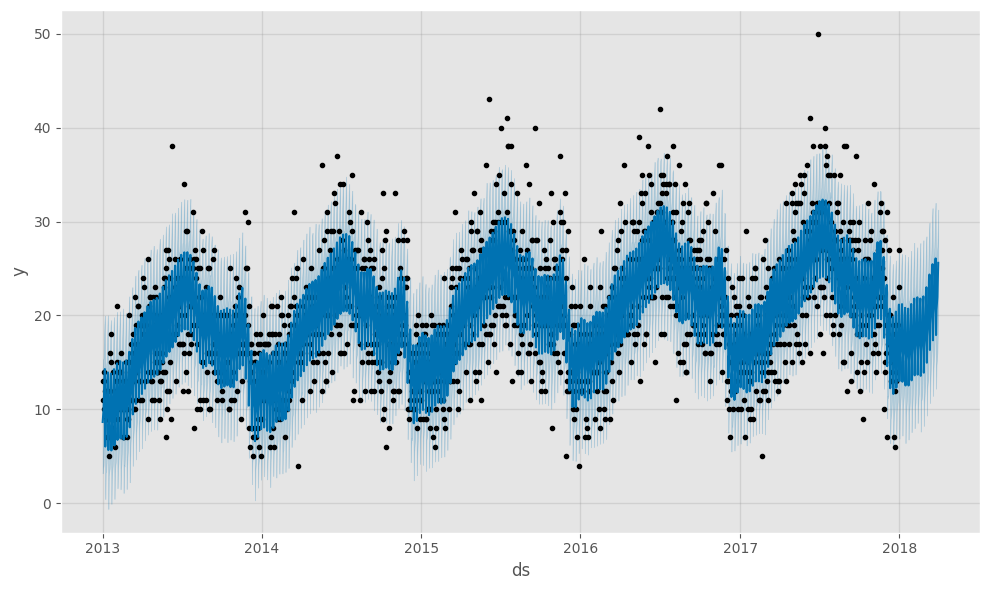

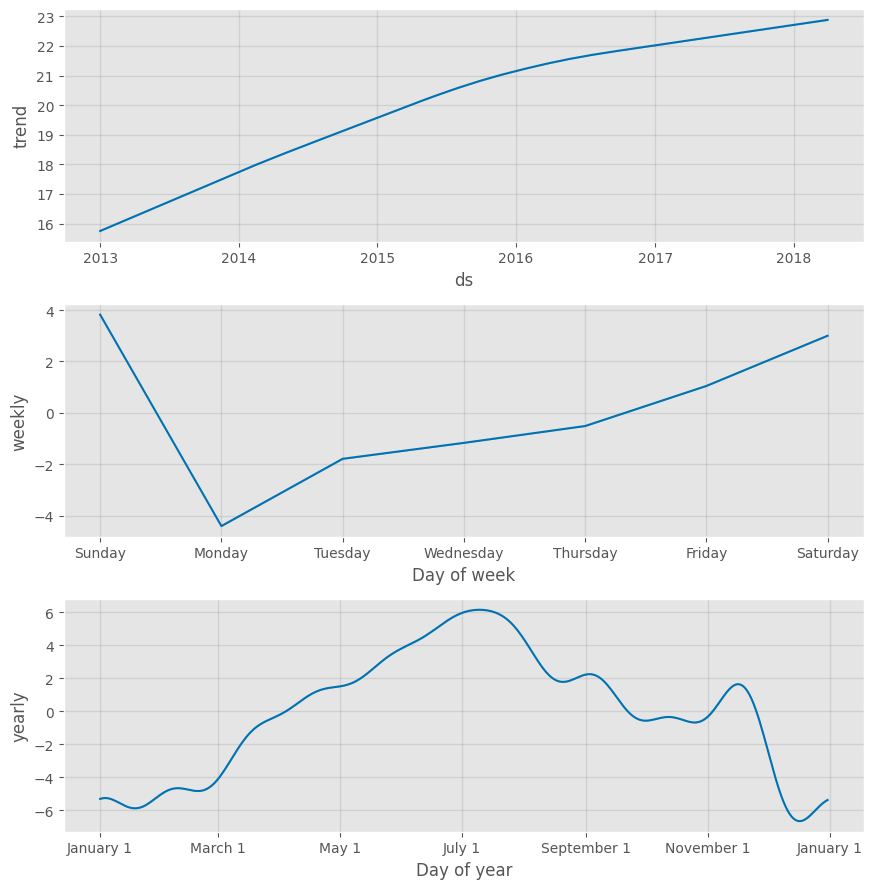

In [5]:
# Store 1, Item 1
df_filtered = train[(train['store'] == 1) & (train['item'] == 1)].copy()

# Prophet-Datensatz vorbereiten
df_prophet = df_filtered[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
df_prophet.head()

# Modell definieren & trainieren
model = Prophet()
model.fit(df_prophet)

# Zukunftsdatenrahmen (90 Tage)
future = model.make_future_dataframe(periods=90)
future.tail()

# Prognose erzeugen
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Forecast-Plot mit echten Daten
fig1 = model.plot(forecast)

# Trend- & Saisonanalyse
fig2 = model.plot_components(forecast)


In [6]:
# Forecast-Qualität bewerten

# Split in Training & Validierung
train_cutoff = df_prophet[:-90]
model_val = Prophet()
model_val.fit(train_cutoff)

future_val = model_val.make_future_dataframe(periods=90)
forecast_val = model_val.predict(future_val)

# Vergleich
actual = df_prophet[-90:].reset_index(drop=True)
pred = forecast_val[-90:].reset_index(drop=True)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(actual['y'], pred['yhat'])
print("Mean Absolute Error (MAE):", mae)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyte_yps8/epi4r0dr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyte_yps8/oi719vnj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87559', 'data', 'file=/tmp/tmpyte_yps8/epi4r0dr.json', 'init=/tmp/tmpyte_yps8/oi719vnj.json', 'output', 'file=/tmp/tmpyte_yps8/prophet_modelml0djqvu/prophet_model-20250719175305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:53:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:53:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error (MAE): 3.764045714175169
